# Deep Q-learning for trading

## Imports, Settings & Helpers

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from pathlib import Path
from time import time
from collections import deque
from random import sample, choice
import string

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import gym
from gym.envs.registration import register

### Settings

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
sns.set_style('whitegrid')

In [5]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [6]:
results_path = Path('results', 'trading_bot')
if not results_path.exists():
    results_path.mkdir(parents=True)

### Helper functions

In [7]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)

## Set up Gym Environment

### Register Trading Environment

In [8]:
trading_days = 252

In [9]:
register(
    id='trading-v0',
    entry_point='trading_env:TradingEnvironment',
    max_episode_steps=trading_days
)

### Initialize Trading Environment

In [10]:
trading_cost_bps = 1e-3
time_cost_bps = 1e-4

In [11]:
start_date = '2010-01-01'
end_date = '2018-03-20'

In [12]:
tickers = ['AAPL']

In [13]:
trading_environment = gym.make('trading-v0', 
                               tickers=tickers,
                               trading_days=trading_days,
                               trading_cost_bps=trading_cost_bps,
                               time_cost_bps=time_cost_bps,
                               start_date=start_date,
                               end_date=end_date)
trading_environment.seed(42)

INFO:trading_env:trading_env logger started.
INFO:trading_env:loading data for AAPL...
INFO:trading_env:got data for AAPL...
INFO:trading_env:preprocessing data for AAPL...
INFO:trading_env:finished preprocessing for AAPL...


[42]

### Get Environment Params

In [14]:
state_dim = trading_environment.observation_space.shape[0]
num_actions = trading_environment.action_space.n
max_episode_steps = trading_environment.spec.max_episode_steps

## Data understanding

In [15]:
df = trading_environment.data_source.data

### Full data set

In [16]:
df

,,returns,ret_2,ret_5,ret_10,ret_21,rsi,macd,atr,stoch,ultosc,bbp,obv,adx
date,ticker,,,,,,,,,,,,,
2010-02-22,AAPL,-0.006218,-0.639123,-0.144441,0.291012,-0.820227,-0.282595,-0.744691,-1.472485,1.419000,0.756052,-1.582043,-2.844524,-0.401087
2010-02-23,AAPL,-0.016750,-1.100732,-1.014938,0.086340,-0.361491,-1.167737,-0.712394,-1.462827,1.967483,-0.010730,-1.702626,-3.017091,-0.403016
2010-02-24,AAPL,0.018253,-0.041435,-0.409033,0.239081,-0.477448,-0.845093,-0.681908,-1.469827,0.881042,-0.115041,-0.084059,-2.878890,-0.408192
2010-02-25,AAPL,0.006698,1.009700,-0.276390,0.489884,-0.576906,0.132019,-0.651473,-1.455847,-1.088606,0.292090,0.671177,-2.679308,-0.457135
2010-02-26,AAPL,0.012970,0.775556,0.256683,0.383047,-0.529646,1.109132,-0.618219,-1.478955,-2.135355,0.498064,1.154086,-2.527035,-0.568718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-14,AAPL,-0.008501,-0.888784,0.391459,-0.181005,1.018401,-0.000086,1.227974,2.545501,1.323553,-0.210158,-0.649510,0.490180,-0.936016
2018-03-15,AAPL,0.001177,-0.417054,0.118880,0.200884,0.886162,-0.932429,1.268920,2.413349,1.981065,-0.284139,-0.938741,0.517288,-0.929406
2018-03-16,AAPL,-0.003526,-0.197776,-0.451769,-0.011198,0.563206,-1.503181,1.279964,2.223450,1.775749,-0.348638,-0.987258,0.473074,-0.937652


--- Shape ---
Number of records: 2032
Number of attributes: 13

--- Types ---
returns    float64
ret_2      float64
ret_5      float64
ret_10     float64
ret_21     float64
rsi        float64
macd       float64
atr        float64
stoch      float64
ultosc     float64
bbp        float64
obv        float64
adx        float64
dtype: object

--- Statistical measures for each attribute ---
           returns         ret_2         ret_5        ret_10        ret_21  \
count  2032.000000  2.032000e+03  2.032000e+03  2.032000e+03  2.032000e+03   
mean      0.001067 -3.933861e-18  2.272898e-17  3.496765e-18 -6.993531e-18   
std       0.015843  1.000246e+00  1.000246e+00  1.000246e+00  1.000246e+00   
min      -0.123549 -6.442942e+00 -3.617858e+00 -3.417642e+00 -2.913519e+00   
25%      -0.006745 -5.288239e-01 -6.282082e-01 -6.503854e-01 -6.574893e-01   
50%       0.000833  7.242677e-03  3.232401e-02  1.275353e-02 -2.482618e-02   
75%       0.009605  5.755875e-01  6.110239e-01  6.585891e-01  6.65

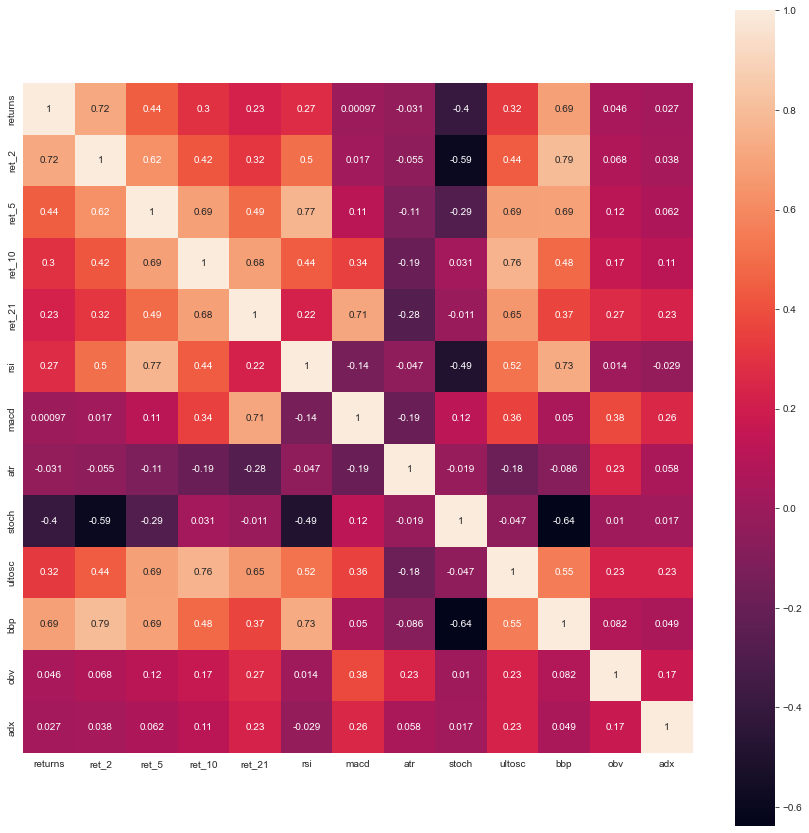

In [17]:
print("--- Shape ---")
print("Number of records:", df.shape[0])
print("Number of attributes:", df.shape[1])
print()
print("--- Types ---")
print(df.dtypes)
print()
print("--- Statistical measures for each attribute ---")
print(df.describe())
print()
print("--- Correlation ---")
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), square=True, annot=True)
plt.show()

### Per ticker data sets

AAPL
                    returns     ret_2     ret_5    ret_10    ret_21       rsi  \
date       ticker                                                               
2010-02-22 AAPL   -0.006218 -0.639123 -0.144441  0.291012 -0.820227 -0.282595   
2010-02-23 AAPL   -0.016750 -1.100732 -1.014938  0.086340 -0.361491 -1.167737   
2010-02-24 AAPL    0.018253 -0.041435 -0.409033  0.239081 -0.477448 -0.845093   
2010-02-25 AAPL    0.006698  1.009700 -0.276390  0.489884 -0.576906  0.132019   
2010-02-26 AAPL    0.012970  0.775556  0.256683  0.383047 -0.529646  1.109132   
...                     ...       ...       ...       ...       ...       ...   
2018-03-14 AAPL   -0.008501 -0.888784  0.391459 -0.181005  1.018401 -0.000086   
2018-03-15 AAPL    0.001177 -0.417054  0.118880  0.200884  0.886162 -0.932429   
2018-03-16 AAPL   -0.003526 -0.197776 -0.451769 -0.011198  0.563206 -1.503181   
2018-03-19 AAPL   -0.015279 -0.919689 -1.130266 -0.389231 -0.129404 -1.503181   
2018-03-20 AAPL   -0.00

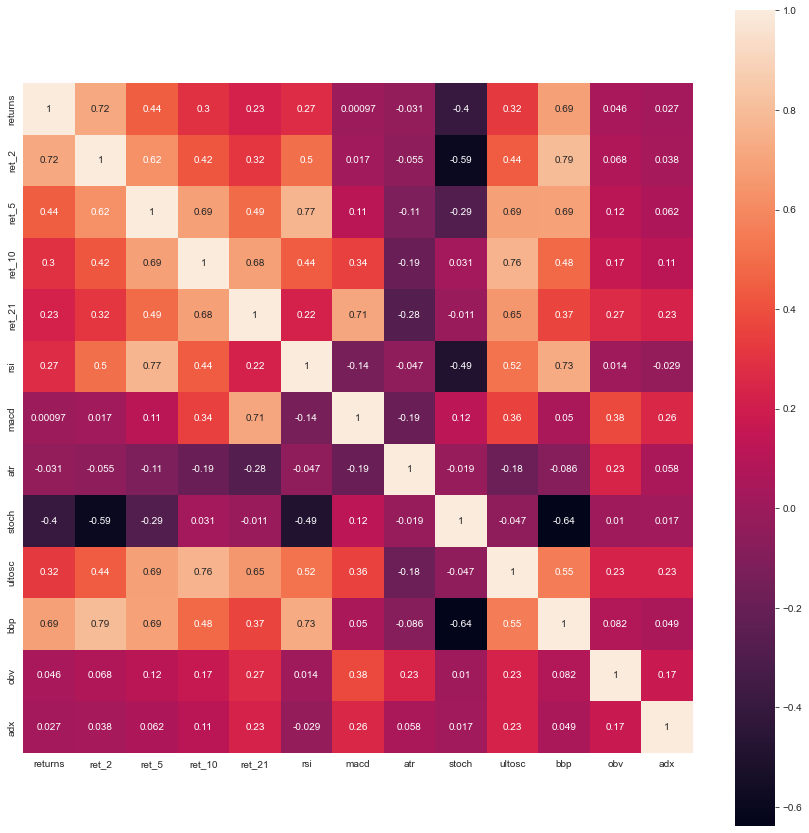

In [18]:
for ticker in tickers:
    print(ticker)
    df_ticker = df.loc[(slice(None), ticker), :]
    print(df_ticker)
    print("--- Shape ---")
    print("Number of records:", df_ticker.shape[0])
    print("Number of attributes:", df_ticker.shape[1])
    print()
    print("--- Types ---")
    print(df_ticker.dtypes)
    print()
    print("--- Statistical measures for each attribute ---")
    print(df_ticker.describe())
    print()
    print("--- Correlation ---")
    plt.figure(figsize=(15, 15))
    sns.heatmap(df_ticker.corr(), square=True, annot=True)
    plt.show()

## Define Trading Agent

In [19]:
class DDQNAgent:
    def __init__(self, state_dim,
                 num_actions,
                 learning_rate,
                 gamma,
                 epsilon_start,
                 epsilon_end,
                 epsilon_decay_steps,
                 epsilon_exponential_decay,
                 replay_capacity,
                 architecture,
                 l2_reg,
                 tau,
                 batch_size,
                 train,
                 ticker):

        self.state_dim = state_dim
        self.num_actions = num_actions
        self.experience = deque([], maxlen=replay_capacity)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.architecture = architecture
        self.l2_reg = l2_reg
        self.ticker = ticker

        self.online_network = self.build_model()
        self.target_network = self.build_model(trainable=False)
        self.update_target()

        if(not train):
            self.epsilon = 0.0
        else:
            self.epsilon = epsilon_start
        self.epsilon_decay_steps = epsilon_decay_steps
        self.epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps
        self.epsilon_exponential_decay = epsilon_exponential_decay
        self.epsilon_history = []

        self.total_steps = self.train_steps = 0
        self.episodes = self.episode_length = self.train_episodes = 0
        self.steps_per_episode = []
        self.episode_reward = 0
        self.rewards_history = []

        self.batch_size = batch_size
        self.tau = tau
        self.losses = []
        self.idx = tf.range(batch_size)
        self.train = train

    def build_model(self, trainable=True):
        layers = []
        # n = len(self.architecture)
        # for i, units in enumerate(self.architecture, 1):
        #     layers.append(Dense(units=units,
        #                         input_dim=self.state_dim if i == 1 else None,
        #                         activation='relu',
        #                         kernel_regularizer=l2(self.l2_reg),
        #                         name=f'Dense_{i}',
        #                         trainable=trainable))
        layers.append(SimpleRNN(units=128, input_dim=self.state_dim))
        layers.append(Dropout(.1))
        layers.append(Dense(units=self.num_actions,
                            name='Output'))
        model = Sequential(layers)
        model.compile(loss='mean_squared_error',
                      optimizer=Adam(lr=self.learning_rate))
        model.trainable = trainable
        return model

    def update_target(self):
        self.target_network.set_weights(self.online_network.get_weights())

    def load_model_weights(self, model_weights_filepath):
        self.online_network.load_weights(model_weights_filepath)
        print('Model weights loaded from: ' + model_weights_filepath)
    
    def save_model_weights(self, num_episodes, folder_id):
        model_weights_filepath = 'weights/{0}_episodes/{1}/model_{2}.h5'.format(num_episodes, folder_id, self.ticker)
        if(not Path(model_weights_filepath).exists()):
            Path(model_weights_filepath).mkdir(parents=True)
        self.online_network.save_weights(model_weights_filepath)
        print('Model weights saved at: ' + model_weights_filepath)

    def epsilon_greedy_policy(self, state):
        self.total_steps += 1
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)
        q = self.online_network.predict(state, verbose=0)
        return np.argmax(q, axis=1).squeeze()

    def memorize_transition(self, s, a, r, s_prime, not_done):
        if not_done:
            self.episode_reward += r
            self.episode_length += 1
        else:
            if self.train:
                if self.episodes < self.epsilon_decay_steps:
                    self.epsilon -= self.epsilon_decay
                else:
                    self.epsilon *= self.epsilon_exponential_decay

            self.episodes += 1
            self.rewards_history.append(self.episode_reward)
            self.steps_per_episode.append(self.episode_length)
            self.episode_reward, self.episode_length = 0, 0

        self.experience.append((s, a, r, s_prime, not_done))

    def experience_replay(self):
        if self.batch_size > len(self.experience):
            return
        minibatch = map(np.array, zip(*sample(self.experience, self.batch_size)))
        states, actions, rewards, next_states, not_done = minibatch

        next_q_values = self.online_network.predict_on_batch(next_states)
        best_actions = tf.argmax(next_q_values, axis=1)

        next_q_values_target = self.target_network.predict_on_batch(next_states)
        target_q_values = tf.gather_nd(next_q_values_target,
                                       tf.stack((self.idx, tf.cast(best_actions, tf.int32)), axis=1))

        targets = rewards + not_done * self.gamma * target_q_values

        q_values = self.online_network.predict_on_batch(states)
        q_values[(self.idx, actions)] = targets

        loss = self.online_network.train_on_batch(x=states, y=q_values)
        self.losses.append(loss)

        if self.total_steps % self.tau == 0:
            self.update_target()

## Define hyperparameters

In [20]:
gamma = .99,  # discount factor
tau = 100  # target network update frequency

### NN Architecture

In [21]:
architecture = (256, 256)  # units per layer
learning_rate = 0.01  # learning rate
l2_reg = 1e-6  # L2 regularization

### Experience Replay

In [22]:
replay_capacity = int(1e6)
batch_size = 4096

### $\epsilon$-greedy Policy

In [23]:
epsilon_start = 1.0
epsilon_end = .01
epsilon_decay_steps = 250
epsilon_exponential_decay = .99

### Trainable

In [24]:
train = True

## Create DDQN Agent

In [25]:
tf.keras.backend.clear_session()

In [26]:
ddqn = {ticker: DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size,
                 train=train,
                 ticker=ticker) for ticker in tickers}

In [27]:
ddqn['AAPL'].online_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               18176     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 Output (Dense)              (None, 3)                 387       
                                                                 
Total params: 18,563
Trainable params: 18,563
Non-trainable params: 0
_________________________________________________________________


## Run Experiment

### Set parameters

In [28]:
total_steps = 0
max_episodes = 700

### Initialize variables

These variables will keep track of the agent results at the end of every episode

In [29]:
episode_time = []
navs = {ticker: [] for ticker in tickers}
market_navs = {ticker: [] for ticker in tickers}
diffs = {ticker: [] for ticker in tickers}
episode_eps = {ticker: [] for ticker in tickers}

### Load model weights

In [30]:
folder_id = 'fsdsgs'
model_weights_filepaths = {ticker: 'weights/100_episodes/{0}/model_{1}.h5'.format(folder_id, ticker) for ticker in tickers}
if(not train):
    for ticker in tickers:
        ddqn[ticker].load_model_weights(model_weights_filepaths[ticker])

### Visualization

In [31]:
def track_results(episode, nav_ma_100, nav_ma_10,
                  market_nav_100, market_nav_10,
                  win_ratio, total, epsilon, ticker):
    time_ma = np.mean([episode_time[-100:]])
    T = np.sum(episode_time)
    
    template = '{:>4d} | {} | Agent: {:>6.1%} ({:>6.1%}) | '
    template += 'Market: {:>6.1%} ({:>6.1%}) | '
    template += 'Wins: {:>5.1%} | eps: {:>6.3f} | {}'
    print(template.format(episode, format_time(total), 
                          nav_ma_100-1, nav_ma_10-1, 
                          market_nav_100-1, market_nav_10-1, 
                          win_ratio, epsilon, ticker))

## Train Agent

In [32]:
start = time()
results = []
for episode in range(1, max_episodes + 1):
    current_states = trading_environment.reset()
    for episode_step in range(max_episode_steps):
        actions = {}
        for ticker in tickers:
            action = ddqn[ticker].epsilon_greedy_policy(current_states[ticker].reshape(-1, state_dim))
            actions[ticker] = action
        
        next_states, rewards, done, _ = trading_environment.step(actions)

        for ticker in tickers:
            ddqn[ticker].memorize_transition(current_states[ticker], 
                                    actions[ticker], 
                                    rewards[ticker], 
                                    next_states[ticker], 
                                    0.0 if done else 1.0)
            if ddqn[ticker].train:
                ddqn[ticker].experience_replay()
        if done:
            break
        current_states = next_states.copy()

    # get DataFrame with seqence of actions, returns and nav values
    result = trading_environment.env.simulator.result()
    
    for ticker in tickers:
        # get results of last step
        final = pd.DataFrame({c: [result[c][ticker][-1]] for c in result.columns}).iloc[0]

        # apply return (net of cost) of last action to last starting nav 
        nav = final.nav * (1 + final.strategy_return)
        navs[ticker].append(nav)

        # market nav 
        market_nav = final.market_nav
        market_navs[ticker].append(market_nav)

        # track difference between agent an market NAV results
        diff = nav - market_nav
        diffs[ticker].append(diff)
    
        if episode % 10 == 0:
            track_results(episode, 
                        # show mov. average results for 100 (10) periods
                        np.mean(navs[ticker][-100:]), 
                        np.mean(navs[ticker][-10:]), 
                        np.mean(market_navs[ticker][-100:]), 
                        np.mean(market_navs[ticker][-10:]), 
                        # share of agent wins, defined as higher ending nav
                        np.sum([s > 0 for s in diffs[ticker][-100:]])/min(len(diffs[ticker]), 100), 
                        time() - start, ddqn[ticker].epsilon, ticker)
        if len(diffs[ticker]) > 25 and all([r > 0 for r in diffs[ticker][-25:]]):
            print(result.tail())
            break
    if episode % 10 == 0:
        print("---------------------------------------------------------------------------------------------------------")

trading_environment.close()

ValueError: in user code:

    File "c:\Users\elkin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\elkin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\elkin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\elkin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\elkin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\elkin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential" "                 f"(type Sequential).
    
    Input 0 of layer "simple_rnn" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 13)
    
    Call arguments received by layer "sequential" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None, 13), dtype=float32)
      • training=False
      • mask=None


### Save trained model

In [ ]:
if(train):
    folder_id = ''.join(choice(string.digits + string.ascii_lowercase) for i in range(10))
    for ticker in tickers:
        ddqn[ticker].save_model_weights(max_episodes, folder_id)

## Results

In [ ]:
for ticker in tickers:
    results = pd.DataFrame({'Episode': list(range(1, episode+1)),
                            'Agent': navs[ticker],
                            'Market': market_navs[ticker],
                            'Difference': diffs[ticker]}).set_index('Episode')

    results['Strategy Wins (%)'] = (results.Difference > 0).rolling(int(max_episodes*0.10)).sum()

    results.to_csv(results_path / 'results_{0}.csv'.format(ticker), index=False)
    
    # Evaluate results
    fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

    df1 = (results[['Agent', 'Market']]
        .sub(1)
        .rolling(int(max_episodes*0.10))
        .mean())
    df1.plot(ax=axes[0],
            title='Annual Returns (Moving Average) - {0}'.format(ticker),
            lw=1)

    df2 = results['Strategy Wins (%)'].div(int(max_episodes*0.10)).rolling(int(max_episodes*0.05)).mean()
    df2.plot(ax=axes[1],
            title='Agent Outperformance (%, Moving Average) - {0}'.format(ticker))

    for ax in axes:
        ax.yaxis.set_major_formatter(
            FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        ax.xaxis.set_major_formatter(
            FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
    axes[1].axhline(.5, ls='--', c='k', lw=1)

    sns.despine()
    fig.tight_layout()
    fig.savefig(results_path / 'performance_{0}'.format(ticker), dpi=300)